In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix

In [3]:
bank = pd.read_csv('https://raw.githubusercontent.com/christianolivamoya/MIAX11-ML/main/data/bank.csv', sep=';')
bank.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3195,33,services,married,primary,no,6904,no,no,telephone,20,nov,114,2,-1,0,unknown,no
4398,57,retired,married,tertiary,no,31,no,no,cellular,19,aug,260,2,-1,0,unknown,no
2695,46,technician,married,tertiary,no,405,no,no,cellular,11,aug,138,3,-1,0,unknown,no
4311,46,admin.,single,secondary,no,1790,yes,no,unknown,5,jun,214,5,-1,0,unknown,no
1815,58,technician,married,secondary,no,175,no,no,cellular,12,aug,92,4,-1,0,unknown,no


Hacemos el preprocesado de los datos como hemos visto previamente.

In [4]:
bank.drop(columns=['day', 'month'], inplace=True)
educ_mapping = {'unknown':0,
                'primary':1,
                'secondary':2, 
                'tertiary':3}
noyes_mapping = {'no':False, 'yes':True}
bank['education'].replace(educ_mapping, inplace=True)
bank['y'].replace(noyes_mapping, inplace=True) # Cambio el target a True (1) o False (0) 
bank['default'].replace(noyes_mapping, inplace=True)
bank['housing'].replace(noyes_mapping, inplace=True)
bank['loan'].replace(noyes_mapping, inplace=True)

features = bank.drop(columns='y')
target = bank['y']

features = pd.get_dummies(features)
features.sample(5)

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,...,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
1837,39,3,True,3,False,False,488,1,-1,0,...,True,False,False,True,False,False,False,False,False,True
264,58,3,False,883,False,False,543,1,78,2,...,False,True,False,True,False,False,True,False,False,False
1983,34,2,False,105,True,False,146,2,171,3,...,False,False,True,True,False,False,True,False,False,False
4218,48,3,False,5057,False,True,37,1,-1,0,...,False,True,False,True,False,False,False,False,False,True
1342,27,2,False,710,True,True,653,1,334,2,...,False,True,False,True,False,False,False,False,True,False


Separamos el dataset en train y test.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=20)

In [7]:
norm_features = ['age','balance','duration','pdays', 'education','campaign','previous']
scaler = StandardScaler()

x_train.loc[:, norm_features] = scaler.fit_transform(x_train.loc[:,norm_features])

# Ojo, no hacemos FIT en test para que utilice media y std de train
x_test.loc[:, norm_features] = scaler.transform(x_test.loc[:, norm_features])

x_train.head()

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,...,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
3108,-0.302862,-1.348721,False,0.106486,True,False,-0.931253,4.873419,-0.411175,-0.322186,...,False,True,False,False,False,True,False,False,False,True
984,1.682476,1.186089,False,0.229871,False,False,-0.161220,0.386931,0.528259,0.821116,...,False,True,False,True,False,False,False,False,True,False
2255,-0.491942,1.186089,False,0.051813,True,False,-0.701392,0.066468,1.279806,0.249465,...,False,False,True,True,False,False,True,False,False,False
612,-1.437341,1.186089,False,-0.483838,False,False,-0.007980,0.066468,-0.411175,-0.322186,...,False,False,True,True,False,False,False,False,False,True
2475,1.682476,-0.081316,False,-0.153581,True,False,-0.004149,0.386931,-0.411175,-0.322186,...,True,False,False,False,False,True,False,False,False,True


In [15]:
dtree = DecisionTreeClassifier(max_depth=7)
_ = dtree.fit(x_train, y_train)

El accuracy de base.  Tomaremos este valor como referencia 
respecto al cálculo de la importancia de características

In [16]:
print(dtree.score(x_test, y_test))

0.8917127071823204


___

In [17]:
from sklearn.inspection import permutation_importance

Calculamos la importancia de características por permutación utilizando
la función disponible en sklearn

In [19]:
pimp_tree = permutation_importance(dtree, x_train, y_train, n_repeats=10)

In [20]:
imp_df = pd.DataFrame({'ft': x_train.columns,
                       'tree_mean': pimp_tree.importances_mean,
                       'tree_std': pimp_tree.importances_std
                      })
imp_df.sort_values('tree_mean', ascending=False, inplace=True)

In [21]:
imp_df_better_tree = imp_df.iloc[:10]
imp_df_better_tree

,ft,tree_mean,tree_std
6,duration,0.077600,0.004331
8,pdays,0.022317,0.001469
30,poutcome_success,0.017920,0.000972
0,age,0.012528,0.001225
23,marital_married,0.011173,0.001632
25,contact_cellular,0.006748,0.001006
1,education,0.004065,0.001086
27,contact_unknown,0.003982,0.000784
3,balance,0.003374,0.000664
7,campaign,0.002268,0.000492


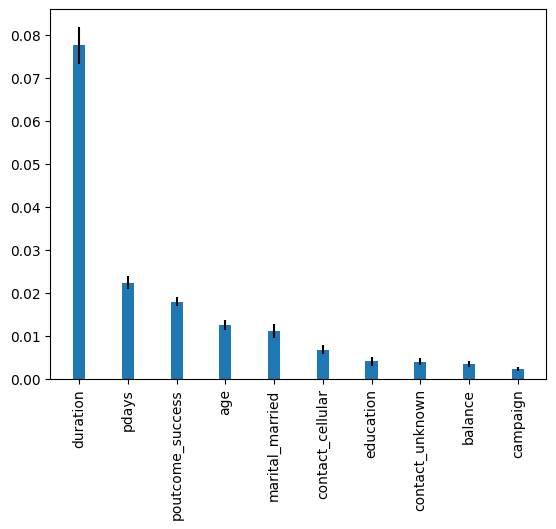

In [23]:
bw=0.25
plt.bar(np.arange(imp_df_better_tree.shape[0]),
                  imp_df_better_tree.tree_mean,
                  yerr=imp_df_better_tree.tree_std,
                  width=bw,
                  tick_label=imp_df_better_tree.ft,
                  )
plt.xticks(rotation=90)
plt.show()

### Propuesta de ejercicio

Vamos a entrenar un árbol con los 10 atributos más significativos para comparar con el rendimiento del modelo original.

In [24]:
x_train_small = x_train[imp_df_better_tree['ft'].values]
x_test_small = x_test[imp_df_better_tree['ft'].values]

In [25]:
x_train_small.head()

,duration,pdays,poutcome_success,age,marital_married,contact_cellular,education,contact_unknown,balance,campaign
3108,-0.931253,-0.411175,False,-0.302862,True,False,-1.348721,True,0.106486,4.873419
984,-0.161220,0.528259,True,1.682476,True,True,1.186089,False,0.229871,0.386931
2255,-0.701392,1.279806,False,-0.491942,False,True,1.186089,False,0.051813,0.066468
612,-0.007980,-0.411175,False,-1.437341,False,True,1.186089,False,-0.483838,0.066468
2475,-0.004149,-0.411175,False,1.682476,False,False,-0.081316,True,-0.153581,0.386931


In [26]:
tree_small = DecisionTreeClassifier(max_depth=7)
_ = tree_small.fit(x_train_small, y_train)

In [27]:
print(tree_small.score(x_test_small, y_test))

0.8861878453038674


Vamos a ver, finalmente, el ratio de score de tree_small frente a tree

In [30]:
tree_small.score(x_test_small, y_test) / dtree.score(x_test, y_test)

0.9938042131350682